In [76]:
import numpy as np
from utils.file_utils import get_config
from dataset.occ_flow_utils import GridMap
config = get_config()
gridmap = GridMap(config)
grid_size_x = config.dataset.grid_size_x
grid_size_y = config.dataset.grid_size_y
test_data = np.load('processed_data/scene_20120.npy', allow_pickle=True).item()
prv_data_dic = test_data['prv']
cur_data_dic = test_data['cur']
nxt_data_dic = test_data['nxt']
print(prv_data_dic['num_vehicles'])
print(cur_data_dic['num_vehicles'])
print(nxt_data_dic['num_vehicles'])
prv_scene_occ_map, prv_scene_flow_map = gridmap.get_map_flow(prv_data_dic)
cur_scene_occ_map, cur_scene_flow_map = gridmap.get_map_flow(cur_data_dic)
nxt_scene_occ_map, nxt_scene_flow_map = gridmap.get_map_flow(nxt_data_dic)
prv_scene_occ_map, prv_scene_flow_map = prv_scene_occ_map.swapaxes(-2, -1), prv_scene_flow_map.swapaxes(-2, -3)
cur_scene_occ_map, cur_scene_flow_map = cur_scene_occ_map.swapaxes(-2, -1), cur_scene_flow_map.swapaxes(-2, -3)
nxt_scene_occ_map, nxt_scene_flow_map = nxt_scene_occ_map.swapaxes(-2, -1), nxt_scene_flow_map.swapaxes(-2, -3)

# change dtype to float32
prv_scene_occ_map = prv_scene_occ_map.astype(np.float32)
cur_scene_occ_map = cur_scene_occ_map.astype(np.float32)
nxt_scene_occ_map = nxt_scene_occ_map.astype(np.float32)

num_time_steps = cur_scene_occ_map.shape[0]


x = np.arange(0, cur_scene_flow_map.shape[2])  # X-axis points (256)
y = np.arange(0, cur_scene_flow_map.shape[1])  # Y-axis points (128)
X, Y = np.meshgrid(x, y)



prv_scene_flow_map_rendered = np.sum(prv_scene_flow_map, axis=0)
cur_scene_flow_map_rendered = np.sum(cur_scene_flow_map, axis=0)
nxt_scene_flow_map_rendered = np.sum(nxt_scene_flow_map, axis=0)
print(prv_scene_flow_map_rendered.shape)
print(cur_scene_flow_map_rendered.shape)
print(nxt_scene_flow_map_rendered.shape)
print(prv_scene_occ_map.shape)
print(cur_scene_occ_map.shape)
print(nxt_scene_occ_map.shape)
print(prv_scene_flow_map.shape)
print(cur_scene_flow_map.shape)
print(nxt_scene_flow_map.shape)

31
31
31
(128, 256, 2)
(128, 256, 2)
(128, 256, 2)
(120, 128, 256)
(120, 128, 256)
(120, 128, 256)
(120, 128, 256, 2)
(120, 128, 256, 2)
(120, 128, 256, 2)


In [74]:
import numpy as np
from utils.file_utils import get_config
from dataset.occ_flow_utils import GridMap
config = get_config()
max = 0
max_file = ''
for i in range(5000):
    file_name = 'processed_data/scene_{}.npy'.format(i)
    test_data = np.load(file_name, allow_pickle=True).item()
    prv_data_dic = test_data['prv']
    cur_data_dic = test_data['cur']
    nxt_data_dic = test_data['nxt']
    if cur_data_dic['num_vehicles'] > max:
        max = cur_data_dic['num_vehicles']
        max_file = file_name
print(file_name, max)


processed_data/scene_4999.npy 37


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import flow_vis

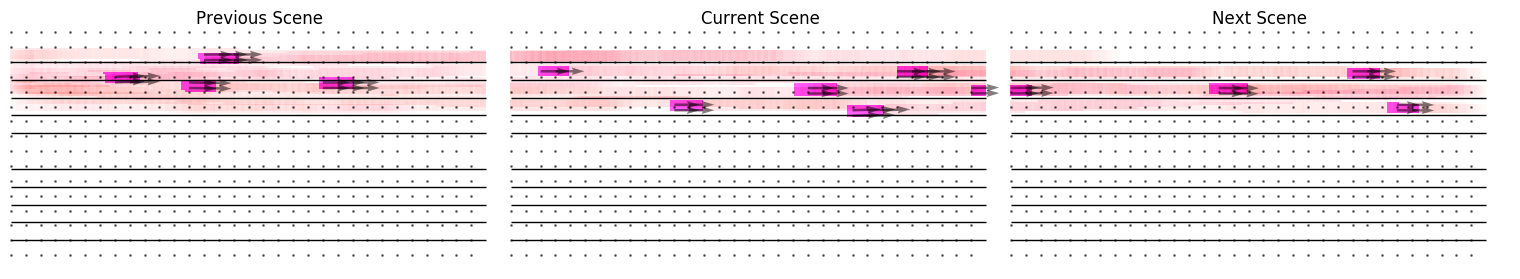

In [78]:
from matplotlib.colors import LinearSegmentedColormap
# Define the custom colormap: white from 0 to 0.5, then gradually red from 0.5 to 1
colors = [
    (1, 1, 1),  # White for 0
    (1, 0.8, 0.8),  # Light red for mid-range
    (1, 0, 1)  # Red for 1
]

# Create the colormap with two segments: 0-0.5 and 0.5-1
cmap = LinearSegmentedColormap.from_list('custom_white_red', colors, N=256)
# cmap = 'YlOrRd'
# start_time = datetime.datetime.fromtimestamp(1638320400)  # Example UNIX timestamp
# start_pos = 5000  # Example starting position (in feet)

# Initialize the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0, 'hspace': 0})
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
# Create the meshgrid for the quiver plot

for ax in axes:
    ax.axis('off')
    
axes[0].set_title('Previous Scene')
axes[1].set_title('Current Scene')
# axes[2].set_title('Next Scene')
flow_rendered_prv = axes[0].imshow(flow_vis.flow_to_color(prv_scene_flow_map_rendered),interpolation='nearest', alpha=1)
flow_rendered_cur = axes[1].imshow(flow_vis.flow_to_color(cur_scene_flow_map_rendered),interpolation='nearest', alpha=1)
flow_rendered_nex = axes[2].imshow(flow_vis.flow_to_color(nxt_scene_flow_map_rendered),interpolation='nearest', alpha=1)
# Initialize the occupancy map with the first frame's data
img_prv = axes[0].imshow(prv_scene_occ_map[0], cmap=cmap, interpolation='nearest', alpha=0.6)
img_cur = axes[1].imshow(cur_scene_occ_map[0], cmap=cmap, interpolation='nearest', alpha=0.6)
img_nxt = axes[2].imshow(nxt_scene_occ_map[0], cmap=cmap, interpolation='nearest', alpha=0.6)
# # Initialize the quiver plot with the first frame's data
# img_prv = axes[0].imshow(flow_vis.flow_to_color(prv_scene_flow_map[0]),interpolation='nearest', alpha=0.6)
# img_cur = axes[1].imshow(flow_vis.flow_to_color(cur_scene_flow_map[0]),interpolation='nearest', alpha=0.6)
# img_nxt = axes[2].imshow(flow_vis.flow_to_color(nxt_scene_flow_map[0]),interpolation='nearest', alpha=0.6)
def downsample(x, y, flow_map, down_sample_x=8, down_sample_y=3):
    """Downsample x, y, and flow_map with different rates for x and y axes."""
    x_down = x[::down_sample_y, ::down_sample_x]
    y_down = y[::down_sample_y, ::down_sample_x]
    flow_map_down = flow_map[:, ::down_sample_y, ::down_sample_x, :]
    return x_down, y_down, flow_map_down


def initialize_quiver(ax, flow_map, x, y):
    """Initialize the quiver plot with downsampled data."""
    x, y, flow_map = downsample(x, y, flow_map)
    mask = (flow_map[0, ..., 0] != 0) | (flow_map[0, ..., 1] != 0)
    X_masked, Y_masked = x[mask], y[mask]
    U_masked, V_masked = flow_map[0, ..., 0][mask], flow_map[0, ..., 1][mask]
    return ax.quiver(X_masked, Y_masked, U_masked, V_masked, 
                     angles='xy', scale_units='xy', scale=0.25, width=0.005, color='black', alpha=0.5)


quiver_prv = initialize_quiver(axes[0], prv_scene_flow_map, X, Y)
quiver_cur = initialize_quiver(axes[1], cur_scene_flow_map, X, Y)
quiver_nxt = initialize_quiver(axes[2], nxt_scene_flow_map, X, Y)



road_lines_y = [12, 24, 36, 48, 60, -12, -24, -36, -48, -60]
# Animation update function
def update(frame):
    """Update both the quiver plot and the occupancy map for each frame."""
    # Update occupancy map
    for ax in axes:
        ax.clear()
        ax.axis('off')
    axes[0].set_title('Previous Scene')
    axes[1].set_title('Current Scene')
    axes[2].set_title('Next Scene')
    axes[0].scatter(X[::8, ::8], Y[::8, ::8], color='black', s=1, alpha=0.5)
    axes[1].scatter(X[::8, ::8], Y[::8, ::8], color='black', s=1, alpha=0.5)
    axes[2].scatter(X[::8, ::8], Y[::8, ::8], color='black', s=1, alpha=0.5)   
    
    flow_rendered_prv = axes[0].imshow(flow_vis.flow_to_color(prv_scene_flow_map_rendered),interpolation='nearest', alpha=1)
    flow_rendered_cur = axes[1].imshow(flow_vis.flow_to_color(cur_scene_flow_map_rendered),interpolation='nearest', alpha=1)
    flow_rendered_nex = axes[2].imshow(flow_vis.flow_to_color(nxt_scene_flow_map_rendered),interpolation='nearest', alpha=1)
    img_prv = axes[0].imshow(prv_scene_occ_map[frame], cmap=cmap, interpolation='nearest', alpha=0.6)
    img_cur = axes[1].imshow(cur_scene_occ_map[frame], cmap=cmap, interpolation='nearest', alpha=0.6)
    img_nxt = axes[2].imshow(nxt_scene_occ_map[frame], cmap=cmap, interpolation='nearest', alpha=0.6)
    # img_prv = axes[0].imshow(flow_vis.flow_to_color(prv_scene_flow_map[frame]),interpolation='nearest', alpha=0.6)
    # img_cur = axes[1].imshow(flow_vis.flow_to_color(cur_scene_flow_map[frame]),interpolation='nearest', alpha=0.6)
    # img_nxt = axes[2].imshow(flow_vis.flow_to_color(nxt_scene_flow_map[frame]),interpolation='nearest', alpha=0.6)
    # Update quiver plot
    def create_quiver(ax, flow_map, x, y):
        x, y, flow_map = downsample(x, y, flow_map)
        mask = (flow_map[frame, ..., 0] != 0) | (flow_map[frame, ..., 1] != 0)
        X_masked, Y_masked = x[mask], y[mask]
        U_masked, V_masked = flow_map[frame, ..., 0][mask], flow_map[frame,..., 1][mask]
        return ax.quiver(X_masked, Y_masked, U_masked, V_masked,
                         angles='xy', scale_units='xy', scale=0.25, width = 0.005, color='black', alpha=0.5)
    
    quiver_prv = create_quiver(axes[0], prv_scene_flow_map, X, Y)
    quiver_cur = create_quiver(axes[1], cur_scene_flow_map, X, Y)
    quiver_nxt = create_quiver(axes[2], nxt_scene_flow_map, X, Y)
    for ax in axes:
        for road_line_y in road_lines_y:
            y_coord = road_line_y * grid_size_y / 160 + grid_size_y / 2
            ax.hlines(
                y=y_coord, xmin=0, xmax=grid_size_x,  # Start and end points on the x-axis
                colors='black', linewidth=1
            )
    #
    return [img_prv, img_cur, img_nxt, quiver_prv, quiver_cur, quiver_nxt]

# Create the animation

ani = animation.FuncAnimation(fig, update, frames=num_time_steps, interval=50, blit=True)

# Save the animation without padding or extra margins
ani.save('flow_occupancy_animation_04.mp4', writer='ffmpeg', fps=20, dpi=300)

# Display the animation
plt.show()

In [13]:
print(prv_scene_flow_map[0,..., 1::4].shape)

(128, 256, 1)


In [65]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


prv_scene_occ_map = prv_data_dic['occupancy_map'].swapaxes(-2, -1)
cur_scene_occ_map = cur_data_dic['occupancy_map'].swapaxes(-2, -1)
nxt_scene_occ_map = nxt_data_dic['occupancy_map'].swapaxes(-2, -1)

# Determine the number of time steps
num_time_steps = cur_scene_occ_map.shape[0]
print(f"Number of time steps: {num_time_steps}")

# Initialize the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Turn off axes for all subplots
for ax in axes:
    ax.axis('off')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.02, hspace=0.1)

# Display the first frame
prv_scene_occ_map_img = axes[0].imshow(prv_scene_occ_map[0], cmap='viridis', interpolation='nearest')
cur_scene_occ_map_img = axes[1].imshow(cur_scene_occ_map[0], cmap='viridis', interpolation='nearest')
nxt_scene_occ_map_img = axes[2].imshow(nxt_scene_occ_map[0], cmap='viridis', interpolation='nearest')

# Set subplot titles
axes[0].set_title('Previous Scene')
axes[1].set_title('Current Scene')
axes[2].set_title('Next Scene')

# Define the update function for animation
def update(frame):
    """Update function to refresh images for each frame."""
    
    prv_scene_occ_map_img.set_data(prv_scene_occ_map[frame])
    cur_scene_occ_map_img.set_data(cur_scene_occ_map[frame])
    nxt_scene_occ_map_img.set_data(nxt_scene_occ_map[frame])
    fig.canvas.draw()
    return [prv_scene_occ_map_img, cur_scene_occ_map_img, nxt_scene_occ_map_img]

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=num_time_steps, interval=50, blit=False
)

# Save the animation to a file
ani.save('DEMO02.mp4', writer='ffmpeg', fps=10, dpi=150)

# Display the animation
plt.show()


KeyError: 'occupancy_map'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Ensure data consistency and handle potential NaN values
prv_scene_occ_map = np.nan_to_num(prv_data_dic['occupancy_map'].swapaxes(-2, -1))
cur_scene_occ_map = np.nan_to_num(cur_data_dic['occupancy_map'].swapaxes(-2, -1))
nxt_scene_occ_map = np.nan_to_num(nxt_data_dic['occupancy_map'].swapaxes(-2, -1))

# Verify the number of time steps and ensure consistency
num_time_steps = cur_scene_occ_map.shape[0]
print(f"Number of time steps: {num_time_steps}")

# Initialize the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Turn off axes for all subplots
for ax in axes:
    ax.axis('off')

# Adjust subplot spacing to avoid overlap
plt.subplots_adjust(wspace=0.02, hspace=0.1)

# Display the first frame for each subplot
prv_scene_occ_map_img = axes[0].imshow(
    prv_scene_occ_map[0], cmap='viridis', interpolation='nearest', animated=True
)
cur_scene_occ_map_img = axes[1].imshow(
    cur_scene_occ_map[0], cmap='viridis', interpolation='nearest', animated=True
)
nxt_scene_occ_map_img = axes[2].imshow(
    nxt_scene_occ_map[0], cmap='viridis', interpolation='nearest', animated=True
)

# Set titles for the subplots
axes[0].set_title('Previous Scene')
axes[1].set_title('Current Scene')
axes[2].set_title('Next Scene')

# Define the update function for the animation
def update(frame):
    """Update images for each frame."""
    prv_scene_occ_map_img.set_data(prv_scene_occ_map[frame])
    cur_scene_occ_map_img.set_data(cur_scene_occ_map[frame])
    nxt_scene_occ_map_img.set_data(nxt_scene_occ_map[frame])

    # Optional: Print debug information to verify updates

    return prv_scene_occ_map_img, cur_scene_occ_map_img, nxt_scene_occ_map_img

# Create the animation using FuncAnimation
ani = animation.FuncAnimation(
    fig, update, frames=num_time_steps, interval=50, blit=True, repeat=True
)

# Save the animation as an MP4 video (make sure ffmpeg is installed)
ani.save('DEMO02.mp4', writer='ffmpeg', fps=10, dpi=150)

# Display the animation in the window
plt.show()


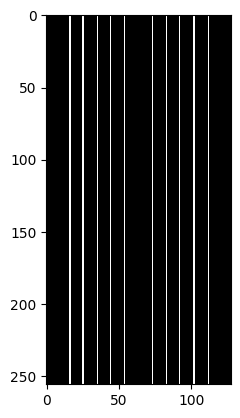

In [5]:
map_img = np.zeros([256, 128,3])

road_lines_y = [12, 24, 36, 48, 60, -12, -24, -36, -48, -60]
# Loop through each road line y-coordinate and draw horizontal lines
for road_line_y in road_lines_y:
    y_coord = road_line_y * 128 / 160 + 128 / 2
    map_img[:,int(y_coord),:] = 1
    
plt.imshow(map_img)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np



prv_scene_occ_map = prv_data_dic['occupancy_map'].swapaxes(-2, -1)
cur_scene_occ_map = cur_data_dic['occupancy_map'].swapaxes(-2, -1)
nxt_scene_occ_map = nxt_data_dic['occupancy_map'].swapaxes(-2, -1)

# Check number of frames (time steps)
num_time_steps = cur_scene_occ_map.shape[0]
print(f"Number of time steps: {num_time_steps}")

# Initialize the figure and 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# Disable axes for all subplots
for ax in axes:
    ax.axis('off')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.02, hspace=0.1)

# Display the first frame of each map
prv_scene_occ_map_img = axes[0].imshow(prv_scene_occ_map[0], cmap='viridis', interpolation='nearest')
cur_scene_occ_map_img = axes[1].imshow(cur_scene_occ_map[0], cmap='viridis', interpolation='nearest')
nxt_scene_occ_map_img = axes[2].imshow(nxt_scene_occ_map[0], cmap='viridis', interpolation='nearest')

# Set titles for each subplot
axes[0].set_title('Previous Scene')
axes[1].set_title('Current Scene')
axes[2].set_title('Next Scene')

# Define the update function for animation
def update(frame):
    """Update function to refresh images in all subplots."""
    prv_scene_occ_map_img.set_data(prv_scene_occ_map[frame])
    cur_scene_occ_map_img.set_data(cur_scene_occ_map[frame])
    nxt_scene_occ_map_img.set_data(nxt_scene_occ_map[frame])
    return prv_scene_occ_map_img, cur_scene_occ_map_img, nxt_scene_occ_map_img

# Create the animation object
ani = animation.FuncAnimation(
    fig, update, frames=num_time_steps, interval=100, blit=False
)

# Save the animation as a video (ensure ffmpeg is installed)
ani.save('DEMO02.mp4', writer='ffmpeg', fps=20, dpi=150)

# Display the animation
plt.show()
